In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


# Create Data Loaders

In [ ]:
from create_dataloaders import get_dataloaders

train_loader, test_loader, label_encoder, crystals = get_dataloaders(
    pkl_path='datasets/seg_maps_dataset.pkl',
    test_size=0.9,
    batch_size=10,
    random_state=42,          
    device='cpu'
)

Классы (кристаллы): ['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond', 'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge', 'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt', 'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Y2O3', 'Zn']


# Initialization of a Two-Dimensional Conditional ViT VAE

In [4]:
from Spatial_Conditional_ViT_VAE_model import ViTVAEForLatentMaps

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model configuration
model = ViTVAEForLatentMaps(
    img_size=(250, 480),
    patch_size=(10, 16),  # 25x30 patches
    in_channels=1,
    embed_dim=512,
    depth=6,
    num_heads=8,
    num_classes=30,
    latent_channels=32,
    dropout=0.1
).to(device)

# model.load_state_dict(torch.load("models/Conditional_ViT_VAE_bound_state.pth"))
model.load_state_dict(torch.load("models/Conditional_ViT_VAE_bound_state_fine_tuned.pth"))

<All keys matched successfully>

# Tests

### Standard diagnostics of the latent space for its parameters

In [ ]:
from tests import LatentSpaceBasicStats

latent_space_stats_eval = LatentSpaceBasicStats(model=model, device=device, mode="Conditional")
latent_space_stats_eval.diagnose(dataloader=test_loader)

══════════════════════════════════════════════════
LATENT SPACE — BASE DIAGNOSTIC
Mode: Conditional
Shape: (1620, 32, 25, 30)
Mean: -0.0014
Std : 0.9918
Min : -5.6226
Max : 5.6920
NaN : False
Inf : False
Noise std (ref): 1.0003
══════════════════════════════════════════════════


{'shape': (1620, 32, 25, 30),
 'mean': -0.00144669390283525,
 'std': 0.9917914867401123,
 'min': -5.622616291046143,
 'max': 5.692022323608398,
 'has_nan': False,
 'has_inf': False,
 'noise_std_reference': 1.0002570152282715}

### Clustering metrics

In [ ]:
from tests import LatentSpaceClusteringEval

latent_space_clustering_eval = LatentSpaceClusteringEval(model=model, device=device, mode="Conditional")
latent_space_clustering_eval.evaluate(dataloader=test_loader)

══════════════════════════════════════════════════
LATENT SPACE — CLUSTERING METRICS
Mode: Conditional
Clustering: {'silhouette': 0.0760391503572464, 'calinski_harabasz': 48.87236022949219, 'davies_bouldin': 3.0114297874189497}
Linear probe: {'linear_probe_mean': 0.6808641975308642, 'linear_probe_std': 0.013036242025890684}
MI proxy: {'mi_proxy_acc': 0.6934156378600823}
══════════════════════════════════════════════════


{'clustering': {'silhouette': 0.0760391503572464,
  'calinski_harabasz': 48.87236022949219,
  'davies_bouldin': 3.0114297874189497},
 'linear_probe': {'linear_probe_mean': 0.6808641975308642,
  'linear_probe_std': 0.013036242025890684},
 'mi_proxy': {'mi_proxy_acc': 0.6934156378600823}}

### Latent space inspection for VAE with two-dimensional latent maps (TSNE visualization)

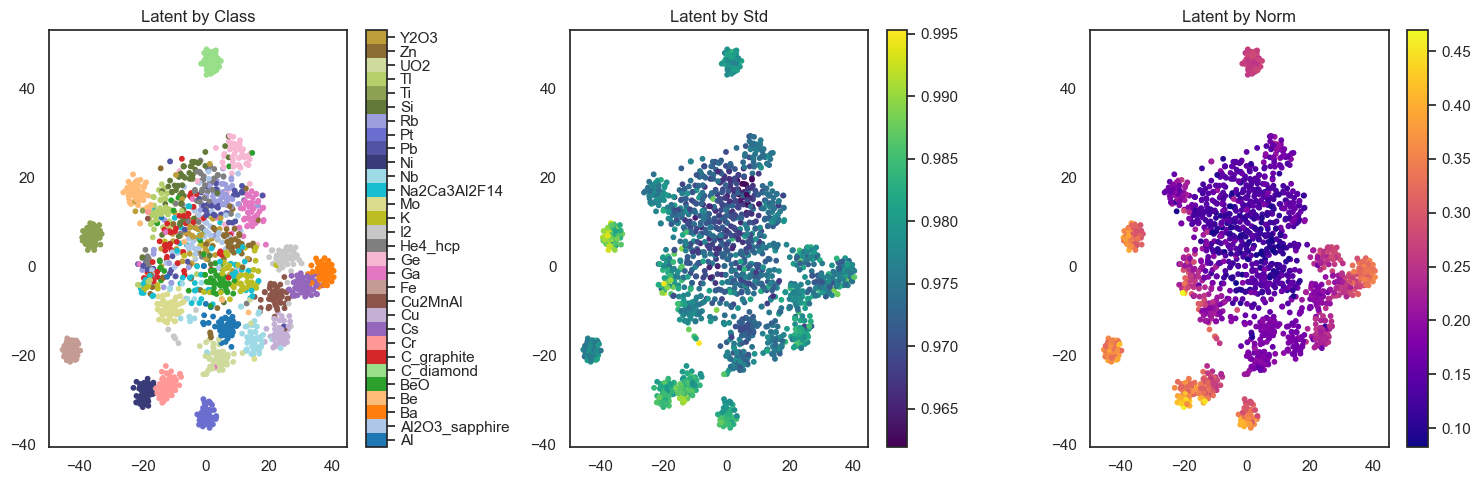

{'z_2d': array([[  1.8660636,   6.2375107],
        [  9.09305  , -13.256308 ],
        [ 24.069035 ,  -6.70928  ],
        ...,
        [ -2.355279 ,   4.05249  ],
        [  9.29984  ,   6.170241 ],
        [-41.038338 , -18.813627 ]], shape=(1620, 2), dtype=float32),
 'labels': array([29,  0, 10, ...,  1, 28, 11], shape=(1620,)),
 'stds': array([0.9839175 , 0.9726119 , 0.9808345 , ..., 0.96613485, 0.97886443,
        0.97803587], shape=(1620,), dtype=float32),
 'norms': array([0.13917398, 0.19494064, 0.18430926, ..., 0.1277189 , 0.13106002,
        0.3687934 ], shape=(1620,), dtype=float32)}

In [ ]:
from tests import LatentSpaceVisualizer

latent_space_visualer = LatentSpaceVisualizer(model=model, device=device, mode="Conditional")
latent_space_visualer.visualize(dataloader=test_loader, method='tsne', class_names=crystals.tolist())

### PSNR and SSIM

In [ ]:
from Generative_Quality_Metrics import PSNR_SSIM_Evaluator

psnr_ssim_eval = PSNR_SSIM_Evaluator(device=device, num_bootstraps=1000)
psnr_ssim_eval.compute(model, test_loader)

Bootstrap PSNR/SSIM: 100%|██████████| 1000/1000 [00:00<00:00, 54780.24it/s]

Mean PSNR: 19.1214 dB  [95% CI: 18.9555 – 19.2828]
Mean SSIM: 0.7841     [95% CI: 0.7797 – 0.7885]


(np.float64(19.121443775671498),
 (np.float64(18.955464243005824), np.float64(19.28283878138036)),
 np.float64(0.7841143002487995),
 (np.float64(0.7796681236889627), np.float64(0.7885494912572113)))

### Initializing ResNet-18 classifier to calculate IS and FID metrics

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Загружаем предобученную ResNet18
classifier = models.resnet18(pretrained=True)

# Изменяем первый сверточный слой
classifier.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Изменяем последний полносвязный слой для вашего количества классов
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, len(crystals))

classifier.to(device)

classifier.load_state_dict(torch.load("models/ResNet_18_classifier_diffractions.pth"))

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### Inception (ResNet) Score

In [ ]:
from Generative_Quality_Metrics import InceptionScoreEvaluator

is_eval = InceptionScoreEvaluator(device=device, num_bootstraps=1000)
is_eval.compute(classifier, model, test_loader)

Bootstrap IS: 100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]

Mean Inception Score: 24.013  [95% CI: 23.449 – 24.521]


(np.float32(24.01299),
 (np.float64(23.448535346984862), np.float64(24.520808696746826)))

### FID


Per-class FID:
Class Al                    FID = 24.024  [95% CI: 21.077 – 27.964]
Class Al2O3_sapphire        FID = 47.198  [95% CI: 44.446 – 50.018]
Class Ba                    FID = 17.559  [95% CI: 14.715 – 21.127]
Class Be                    FID = 38.940  [95% CI: 36.396 – 41.956]
Class BeO                   FID = 40.795  [95% CI: 36.566 – 46.162]
Class C_diamond             FID = 34.538  [95% CI: 32.070 – 37.523]
Class C_graphite            FID = 55.417  [95% CI: 52.333 – 58.991]
Class Cr                    FID = 350.580  [95% CI: 342.046 – 360.239]
Class Cs                    FID = 14.225  [95% CI: 11.584 – 16.923]
Class Cu                    FID = 80.528  [95% CI: 72.893 – 87.714]
Class Cu2MnAl               FID = 42.155  [95% CI: 36.760 – 47.969]
Class Fe                    FID = 113.195  [95% CI: 106.707 – 119.159]
Class Ga                    FID = 47.457  [95% CI: 45.311 – 50.288]
Class Ge                    FID = 44.586  [95% CI: 40.855 – 48.793]
Class He4_hcp             

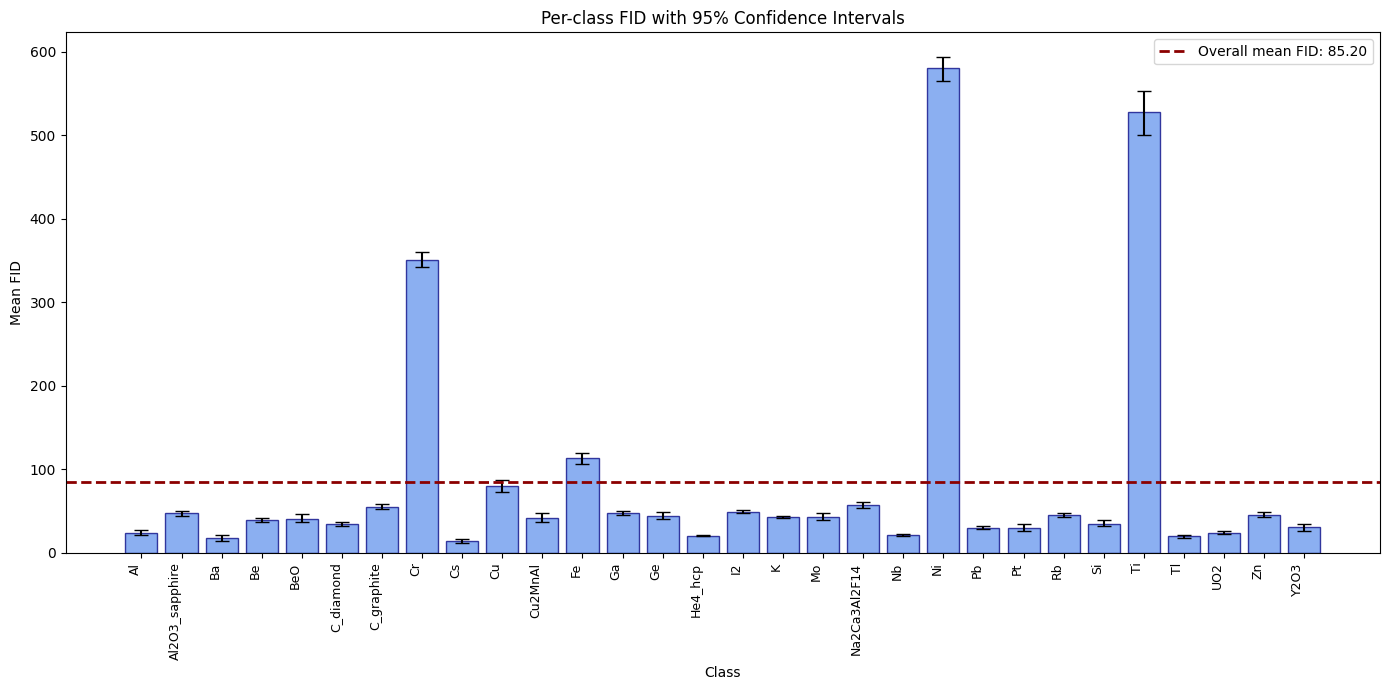

np.float64(85.20355973298462)

In [ ]:
from Generative_Quality_Metrics import FID_Evaluator

fid_eval = FID_Evaluator(device=device, class_names=crystals, num_bootstraps=300)
fid_eval.compute(classifier, model, test_loader)

### Physycal Metrics

Evaluating physical diffraction metrics (Conditional mode)...
Latent shape: (32, 25, 30)


Physical divergence eval: 100%|██████████| 162/162 [00:14<00:00, 11.24it/s]



INTEGRATED INTENSITY DIVERGENCE
Integral intensity:
  Mean:   1.3247
  Std:    1.7901
  Min:    0.0018
  Max:    17.0762
  Samples: 1620
--------------------------------------------------

PEAK SHAPE DIVERGENCE
Peak shape:
  Mean:   0.0133
  Std:    0.0073
  Min:    0.0004
  Max:    0.0423
  Samples: 1620
--------------------------------------------------



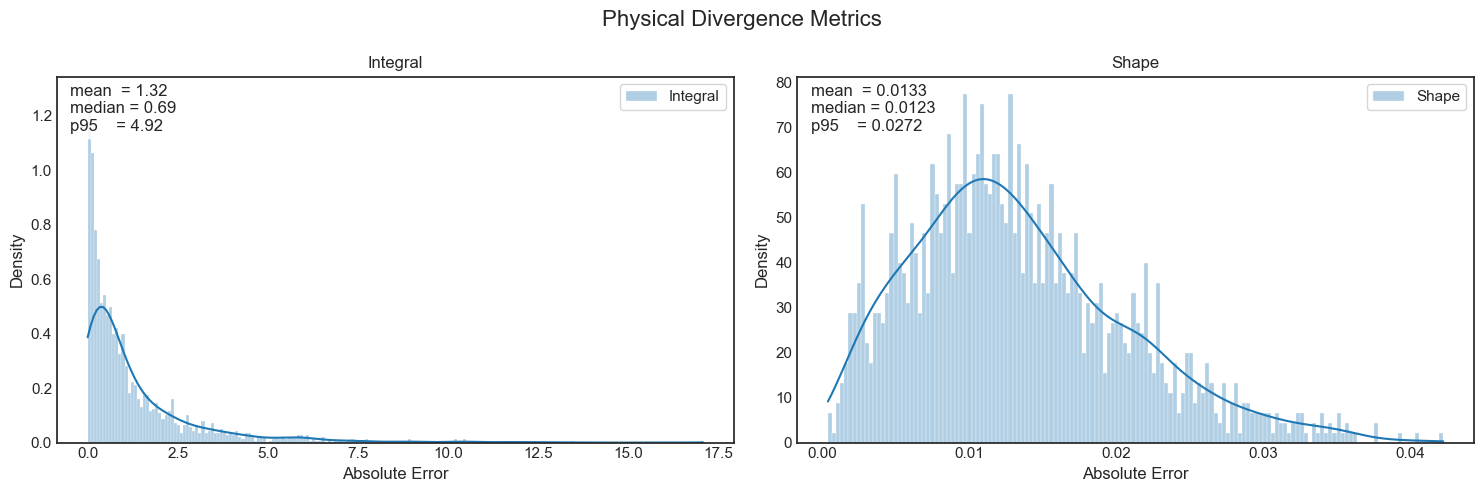

{'raw_metrics': {'integral': array([0.0922421 , 0.84771963, 0.39570148, ..., 3.51609103, 4.93376215,
         0.97366633], shape=(1620,)),
  'shape': array([0.01044732, 0.00429037, 0.02353498, ..., 0.02619002, 0.02466024,
         0.01427358], shape=(1620,))},
 'summary': {'integral': {'mean': 1.3247206349012126,
   'std': 1.7900819478689916,
   'min': 0.0018477518741232552,
   'max': 17.076193960199948,
   'count': 1620},
  'shape': {'mean': 0.013344772588729615,
   'std': 0.007348702299862794,
   'min': 0.00039555840038919956,
   'max': 0.042258158363872776,
   'count': 1620}}}

In [ ]:
from Diffraction_metrics_Calculator import DiffractionMetricsCalculator
from physical_diffraction_metrics import PhysicalDiffractionEvaluator

fixed_centers_d = np.linspace(0.05318052, 7.49710258, 1241)

calculator = DiffractionMetricsCalculator(fixed_centers_pred=fixed_centers_d,
                                        fixed_centers_true=fixed_centers_d,
                                        device=device)

phys_diff_eval = PhysicalDiffractionEvaluator(model=model, calculator=calculator, device=device, mode="Conditional", latent_channels=32, latent_spatial=(25,30))
phys_diff_eval.evaluate(dataloader=test_loader)

# Initialization of a Two-Dimensional UnConditional ViT VAE

In [11]:
from Sapatial_UnConditional_ViT_VAE_model import ViTVAEForLatentMaps

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model configuration
model = ViTVAEForLatentMaps(img_size=(250, 480), patch_size=(10, 16), in_channels=1,
                 embed_dim=512, depth=6, num_heads=8, mlp_ratio=2.0,
                 latent_channels=32, dropout=0.1).to(device)

# model.load_state_dict(torch.load("models/Conditional_ViT_VAE_bound_state.pth"))

# Train Piplines an strategy (Beta)

In [11]:
import torch

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,  # Чуть выше начальный LR
    betas=(0.9, 0.999),
    eps=1e-8,  # Стандартное значение
    weight_decay=1e-4  # Увеличьте weight decay для лучшей регуляризации
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma=0.1
)

In [12]:
from spatial_trainer import VAETrainer
from Spatial_loss_functions import basic_vae_loss, clustering_pull_loss, clustering_push_pull_loss

# === 1. Самый простой сценарий ===

trainer = VAETrainer(
    model=model,
    train_loader=train_loader,           # (img, label)
    optimizer=optimizer,
    loss_fn=basic_vae_loss,
    mode="Conditional",
    require_labels_in_loss=True,         # по умолчанию True
    grad_accum_steps=12,
    static_params={"kl_weight": 1.0},

)

trainer.train(num_epochs=200)

c:\Users\neUral\Desktop\Generative Crystallography\spatial_trainer.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if use_amp else None
Epoch 000:   0%|          | 0/162 [00:00<?, ?it/s]c:\Users\neUral\Desktop\Generative Crystallography\spatial_trainer.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
Epoch 000: 100%|██████████| 162/162 [00:46<00:00,  3.50it/s]


Epoch 000 | Loss: 0.4179 | Recon: 0.3679 | Kl: 0.0499


Epoch 001: 100%|██████████| 162/162 [00:45<00:00,  3.55it/s]


Epoch 001 | Loss: 0.1905 | Recon: 0.1806 | Kl: 0.0099


Epoch 002:  42%|████▏     | 68/162 [00:19<00:26,  3.49it/s]


KeyboardInterrupt: 

In [15]:
from spatial_trainer import VAETrainer
from Spatial_loss_functions import basic_vae_loss, clustering_pull_loss, clustering_push_pull_loss

# === 2. С pull-clustering ===
def beta_schedule(e): return min(1.0, e / 60)
def gamma_schedule(e):
    if e < 30: return 0.0
    return min(0.8, (e - 30) / 40 * 0.8)

trainer = VAETrainer(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    loss_fn=clustering_pull_loss,
    require_labels_in_loss=True,         # по умолчанию True
    grad_accum_steps=12,
    param_schedulers={"beta": beta_schedule, "gamma": gamma_schedule},
    static_params={
        "free_bits_channel": 0.5,
        "recon_weight": 1.0
    },
)
trainer.train(200)

Epoch 000: 100%|██████████| 162/162 [00:46<00:00,  3.47it/s]


Epoch 000 | Loss: 0.3577 | Recon: 0.3577 | Kl: 1.2449 | Cluster: 0.0003 | beta=0.0000, gamma=0.0000


Epoch 001: 100%|██████████| 162/162 [00:46<00:00,  3.51it/s]


Epoch 001 | Loss: 0.1917 | Recon: 0.1762 | Kl: 0.9277 | Cluster: 0.0029 | beta=0.0167, gamma=0.0000


Epoch 002:  12%|█▏        | 20/162 [00:05<00:41,  3.42it/s]


KeyboardInterrupt: 

In [12]:
from spatial_trainer import VAETrainer
from Spatial_loss_functions import basic_vae_loss, clustering_pull_loss, clustering_push_pull_loss

# === 3. С push-pull (твой самый сложный) ===
def beta_schedule(e): return min(1.0, e / 50)
def gamma_pull_schedule(e):
    if e < 30: return 0.0
    return min(0.2, (e - 30) / 30 * 0.2)
def gamma_push_schedule(e):
    if e < 120: return 0.0
    return min(0.0005, (e - 60) / 40 * 0.0005)   # как у тебя

trainer = VAETrainer(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    loss_fn=clustering_push_pull_loss,
    require_labels_in_loss=True,         # по умолчанию True
    grad_accum_steps=12,
    param_schedulers={
        "beta": beta_schedule,
        "gamma_pull": gamma_pull_schedule,
        "gamma_push": gamma_push_schedule,
    },
    static_params={
        "free_bits_channel": 0.02,
        "margin": 1.0,
        "recon_weight": 1.0,
    },
)

trainer.train(num_epochs=200)
trainer.train(200)

c:\Users\neUral\Desktop\Generative Crystallography\spatial_trainer.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if use_amp else None
Epoch 000:   0%|          | 0/162 [00:00<?, ?it/s]c:\Users\neUral\Desktop\Generative Crystallography\spatial_trainer.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
Epoch 000: 100%|██████████| 162/162 [00:47<00:00,  3.43it/s]


Epoch 000 | Loss: 0.3522 | Recon: 0.3522 | Kl: 1.2956 | Pull: 0.0001 | Push: 0.0004 | beta=0.0000, gamma_pull=0.0000, gamma_push=0.0000


Epoch 001: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]


Epoch 001 | Loss: 0.2011 | Recon: 0.1796 | Kl: 1.0750 | Pull: 0.0001 | Push: 0.0063 | beta=0.0200, gamma_pull=0.0000, gamma_push=0.0000


Epoch 002: 100%|██████████| 162/162 [00:45<00:00,  3.53it/s]


Epoch 002 | Loss: 0.1777 | Recon: 0.1732 | Kl: 0.1104 | Pull: 0.0007 | Push: 0.0227 | beta=0.0400, gamma_pull=0.0000, gamma_push=0.0000


Epoch 003: 100%|██████████| 162/162 [00:47<00:00,  3.44it/s]


Epoch 003 | Loss: 0.1672 | Recon: 0.1629 | Kl: 0.0715 | Pull: 0.0002 | Push: 0.0621 | beta=0.0600, gamma_pull=0.0000, gamma_push=0.0000


Epoch 004: 100%|██████████| 162/162 [00:46<00:00,  3.51it/s]


Epoch 004 | Loss: 0.1335 | Recon: 0.1254 | Kl: 0.1015 | Pull: 0.0004 | Push: 0.0458 | beta=0.0800, gamma_pull=0.0000, gamma_push=0.0000


Epoch 005:  36%|███▌      | 58/162 [00:16<00:30,  3.47it/s]


KeyboardInterrupt: 